In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns, math, os
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, VECMResults
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

from scipy import stats


import keras
import keras_tuner
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras_tuner import RandomSearch


from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


url = "https://raw.githubusercontent.com/Levash0v/VECM/main/market_hash_data.csv"
df = pd.read_csv(url)

if 'date' in df.columns:
    # Преобразуем его в формат datetime и устанавливаем как индекс
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
df = df.asfreq('D')   
df = df.loc[df['market_price_usd'] >= 1]
df


,market_price_usd,hash_rate
date,,
2011-02-11,1.080000,2.468411e-01
2011-02-12,1.030000,2.455487e-01
2011-02-13,1.090000,2.636418e-01
2011-02-14,1.080000,2.403793e-01
2011-02-15,1.080000,2.739807e-01
...,...,...
2024-10-01,60837.007812,6.212101e+08
2024-10-02,60632.785156,6.243497e+08
2024-10-03,60759.402344,6.278010e+08


In [32]:
df_C = df.copy()
df_M = df_C.resample('M').mean()

df_M['log_price'] = np.log(df_M['market_price_usd'])
df_M['log_hash_rate'] = np.log(df_M['hash_rate'])

df_M = df_M.dropna()

df_M

,market_price_usd,hash_rate,log_price,log_hash_rate
date,,,,
2011-02-28,1.052727,3.077476e-01,0.051384,-1.178475
2011-04-30,1.623333,7.854056e-01,0.484482,-0.241555
2011-05-31,6.481290,2.214239e+00,1.868920,0.794909
2011-06-30,19.442333,8.345550e+00,2.967453,2.121729
2011-07-31,14.823226,1.244123e+01,2.696195,2.521016
...,...,...,...,...
2024-06-30,65899.465755,5.833065e+08,11.095886,20.184223
2024-07-31,62804.542087,6.039801e+08,11.047783,20.219052
2024-08-31,59921.197581,6.316735e+08,11.000786,20.263883


##### Тест Дики-Фуллера для остатков модели VECM:

Нулевая гипотеза H0: Временной ряд имеет единичный корень, то есть он нестационарный.


Альтернативная гипотеза H1: Временной ряд не имеет единичного корня, то есть он стационарный.

In [39]:
vecm = VECM(endog=df_M[['log_price', 'log_hash_rate']].values, k_ar_diff=24, coint_rank=1)
vecm_fit = vecm.fit()

residuals = vecm_fit.resid

# Остатки переменной 'market_price_usd'
adf_result = adfuller(residuals[:, 0])
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Test Statistic: -12.32342019679883
p-value: 6.671527952690942e-23
Critical Value 1%: -3.47864788917503
Critical Value 5%: -2.882721765644168
Critical Value 10%: -2.578065326612056


##### Данные по остаткам модели VECM стационарны и находлятся на уровне значимости даже ниже критического значения 1%. 
Результаты статистических тестов показывают, что нулевая гипотеза о нестационарности остатков модели VECM отвергается. Отсутствие автокорреляции в остатках является положительным показателем, так как указывает на то, что модель VECM достаточно хорошо захватывает динамику между переменными log_price и log_hash_rate.


##### Коинтеграционные векторы: 
Для модель VECM необходимо провести анализ на наличие коинтеграции, сделаем это с помощью теста Йохансена. Чтобы определить количество и структуру коинтеграционных векторов, которые отражают долгосрочные отношения между переменными.

In [40]:
# Подготовка данных для теста Йохансена (объединяем price и hashrate в один датафрейм)
johansen_test = df_M[['log_price', 'log_hash_rate']]

# Применяем тест Йохансена
result = coint_johansen(johansen_test, det_order=1, k_ar_diff=1)

# Печатаем результаты теста Йохансена (сравниваем с критическими значениями на уровне значимости 5%)
print('Test statistic for Johansen:', result.lr1)  # статистика теста
print('Critical values for Johansen (1%):', result.cvt[:, 2])  # критическое значение на уровне 5%
print('Critical values for Johansen (5%):', result.cvt[:, 1])
print('Critical values for Johansen (10%):', result.cvt[:, 0])

Test statistic for Johansen: [23.2326914   0.95079915]
Critical values for Johansen (1%): [23.1485  6.6349]
Critical values for Johansen (5%): [18.3985  3.8415]
Critical values for Johansen (10%): [16.1619  2.7055]


In [10]:
# Вычислим выбор порядка отставания на основе каждого из доступных информационных критериев.
lag = select_order(data=df_M[['log_price', 'log_hash_rate']], maxlags=24)

lag.summary()


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

,AIC,BIC,FPE,HQIC
0,-7.653,-7.526,0.0004747,-7.601
1,-8.191,-7.980*,0.0002772,-8.105*
2,-8.164,-7.868,0.0002849,-8.043
3,-8.160,-7.780,0.0002859,-8.006
4,-8.161,-7.697,0.0002858,-7.972
5,-8.113,-7.564,0.0003001,-7.890
6,-8.160,-7.527,0.0002864,-7.903
7,-8.163,-7.445,0.0002858,-7.871
8,-8.131,-7.328,0.0002954,-7.805
9,-8.143,-7.256,0.0002922,-7.782


In [44]:
# Построение модели VECM
vecm = VECM(endog=df_M[['log_price', 'log_hash_rate']].values, k_ar_diff=22, coint_rank=1)  # rank=1 для коинтеграции
vecm_fit = vecm.fit()
residuals = vecm_fit.resid

# Печать резульатов модели
print(vecm_fit.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation y1
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.y1          0.4496      0.085      5.300      0.000       0.283       0.616
L1.y2          0.4536      0.196      2.313      0.021       0.069       0.838
L2.y1         -0.1734      0.091     -1.902      0.057      -0.352       0.005
L2.y2         -0.3319      0.233     -1.425      0.154      -0.789       0.125
L3.y1          0.1369      0.092      1.482      0.138      -0.044       0.318
L3.y2          0.2599      0.235      1.104      0.270      -0.201       0.721
L4.y1         -0.0258      0.097     -0.265      0.791      -0.217       0.165
L4.y2         -0.3322      0.236     -1.405      0.160      -0.795       0.131
L5.y1         -0.0521      0.096     -0.545      0.586      -0.240       0.135
L5.y2          0.4519      0.231      1.954      

На первом лаге переменные y1(автокорреляция) и y2 оказывают положительное влияние на y1 с высокой статистической значимостью (P < 0.05), при этом y1 оказывает слабое положительное влияние на y2. 

На лаге 15 y2 оказывает сильное положительное влияние (P = 0.007) на y1. 

Значимость уравнения 𝑒𝑐₁ для 𝑦₁ подразумевает, что 𝑦₁ является переменной, которая корректируется в коинтеграционном отношении, что значает что y1(цена) отвечает за восстановление равновесия(при отклонении) в уравнении. 

Коэффициенты beta.1 и  beta.2 предполагают, что долгосрочное равновесие между переменными можно выразить как: y1=0.5268⋅y2+константа.


In [16]:
# тестирование значимости лагов в моделе VAR
from statsmodels.tsa.ar_model import ar_select_order

price = df_M['log_price'].values
hash_ = df_M['log_hash_rate'].values

lag_order = ar_select_order(endog=price, ic='bic', exog=hash_, maxlag=20)
lag_order.ar_lags

[1, 2]

In [17]:
lag_order = ar_select_order(endog=price, ic='bic', glob=True, exog=hash_, maxlag=20)
lag_order.ar_lags

[1, 2, 6, 10, 19]

In [116]:
lag_order = ar_select_order(endog=price, ic='hqic', glob=True, exog=hash_, maxlag=18)
lag_order.ar_lags

[1, 2, 6, 10, 18]

Метрики для 'log_price':
  MAE: 0.4691
  MSE: 0.3025
  RMSE: 0.5500
  MAPE: 4.3246
  MSLE: 0.0022


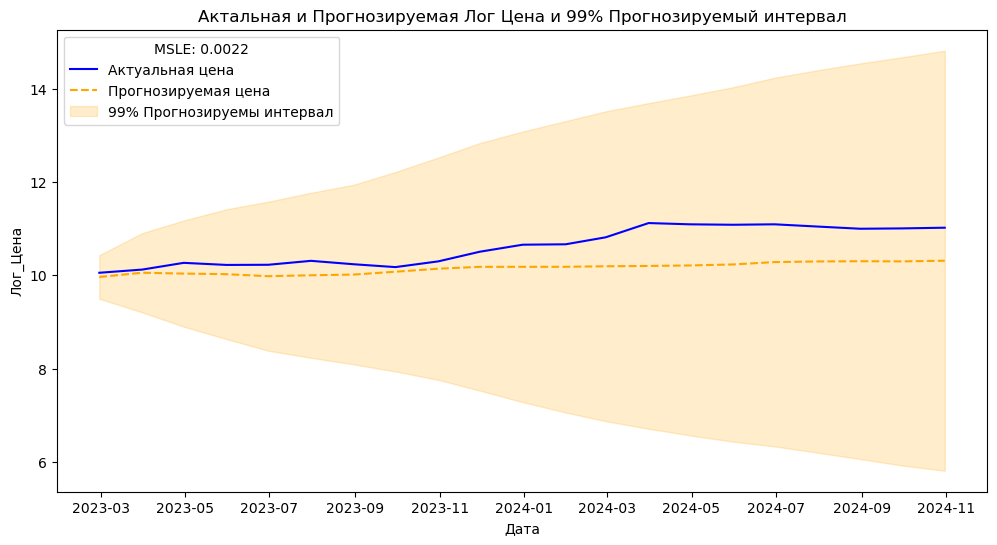

Alpha: 0.01
Lower Bound: [9.49776513 9.20684186 8.89954569 8.63250348 8.38398777]
Upper Bound: [10.43335864 10.90669805 11.17773772 11.41917486 11.58106884]


In [45]:
# Построение модели прогноза цены биткоин моделью VECM, первый вариант реализации
df_12 = df_M[['log_price', 'log_hash_rate']]

# Функция для расчета метрик
def calculate_metrics(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100  # Процентное отклонение
    
    # Добавляем расчет MSLE
    msle = np.mean(np.square(np.log1p(true_values) - np.log1p(predicted_values)))  # Логарифмируем и рассчитываем квадрат разницы
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'MSLE': msle
    }

# Предполагается, что df — это DataFrame с историческими данными, включающими "market_price_usd"
# Разделение на обучающие и тестовые данные
train_data = df_12.iloc[:-21]
test_data = df_12.iloc[-21:]

# Обучение модели VECM
model = VECM(train_data, k_ar_diff=15, coint_rank=1)
vecm_fit = model.fit()

# Прогнозирование на тестовой выборке с интервалом доверия alpha=0.05
alpha = 0.01
forecast, lower, upper = vecm_fit.predict(steps=21, alpha=alpha)
forecast_df = pd.DataFrame(forecast, columns=test_data.columns)
lower_df = pd.DataFrame(lower, columns=test_data.columns)
upper_df = pd.DataFrame(upper, columns=test_data.columns)

# Выбор только "market_price_usd" для расчета метрик
true_values = test_data["log_price"].values
predicted_values = forecast_df["log_price"].values
lower_values = lower_df["log_price"].values
upper_values = upper_df["log_price"].values

# Расчет метрик
metrics = calculate_metrics(true_values, predicted_values)
print("Метрики для 'log_price':")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.4f}")

# Визуализация "market_price_usd" с интервалом доверия
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, true_values, label="Актуальная цена", color="blue")
plt.plot(test_data.index, predicted_values, label="Прогнозируемая цена", color="orange", linestyle="--")

# Отображение интервала доверия
plt.fill_between(test_data.index, lower_values, upper_values, color="orange", alpha=0.2, label=f"{(1-alpha)*100:.0f}% Прогнозируемы интервал")

# Добавление MSLE в легенду
msle_value = metrics['MSLE']
plt.legend(title=f"MSLE: {msle_value:.4f}", loc='upper left')

# Настройка графика
plt.title("Актальная и Прогнозируемая Лог Цена и 99% Прогнозируемый интервал")
plt.xlabel("Дата")
plt.ylabel("Лог_Цена")
plt.show()

print(f"Alpha: {alpha}")
print("Lower Bound:", lower_values[:5])  # Печать первых 5 значений для анализа
print("Upper Bound:", upper_values[:5])


Метрики для 'market_price_usd':
  MAE: 11892.8528
  MSE: 196980678.7822
  RMSE: 14034.9805
  MAPE: 23.6728


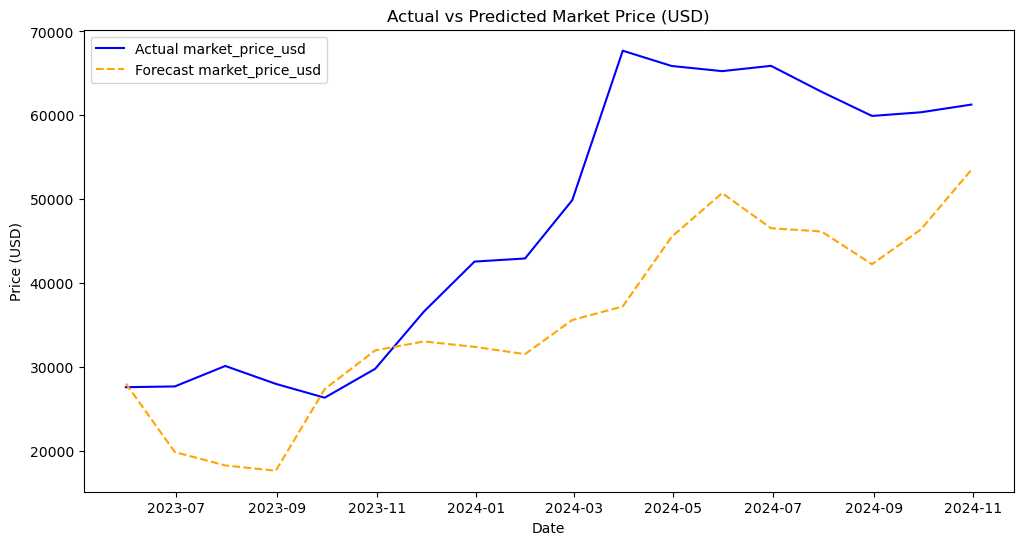

In [46]:
# Построение модели прогноза цены биткоин моделью VECM, второй вариант реализации
# Функция для расчета метрик
def calculate_metrics(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100  # Процентное отклонение
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

# Предполагается, что df — это DataFrame с историческими данными, включающими "market_price_usd"
# Разделение на обучающие и тестовые данные df_M[['log_price', 'log_hash_rate']]
train_data = df_M.iloc[:-18]
test_data = df_M.iloc[-18:]

# Обучение модели VECM
model = VECM(train_data, k_ar_diff=16, coint_rank=1)
vecm_fit = model.fit()

# Прогнозирование на тестовой выборке
forecast = vecm_fit.predict(steps=18)
forecast_df = pd.DataFrame(forecast, columns=test_data.columns)

# Выбор только "market_price_usd" для расчета метрик
true_values = test_data["market_price_usd"].values
predicted_values = forecast_df["market_price_usd"].values

# Расчет метрик
metrics = calculate_metrics(true_values, predicted_values)
print("Метрики для 'market_price_usd':")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.4f}")

# Визуализация "market_price_usd"
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, true_values, label="Actual market_price_usd", color="blue")
plt.plot(test_data.index, predicted_values, label="Forecast market_price_usd", color="orange", linestyle="--")

# Настройка графика
plt.title("Actual vs Predicted Market Price (USD)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc='upper left')
plt.show()


  0%|          | 0/15 [00:00<?, ?it/s]

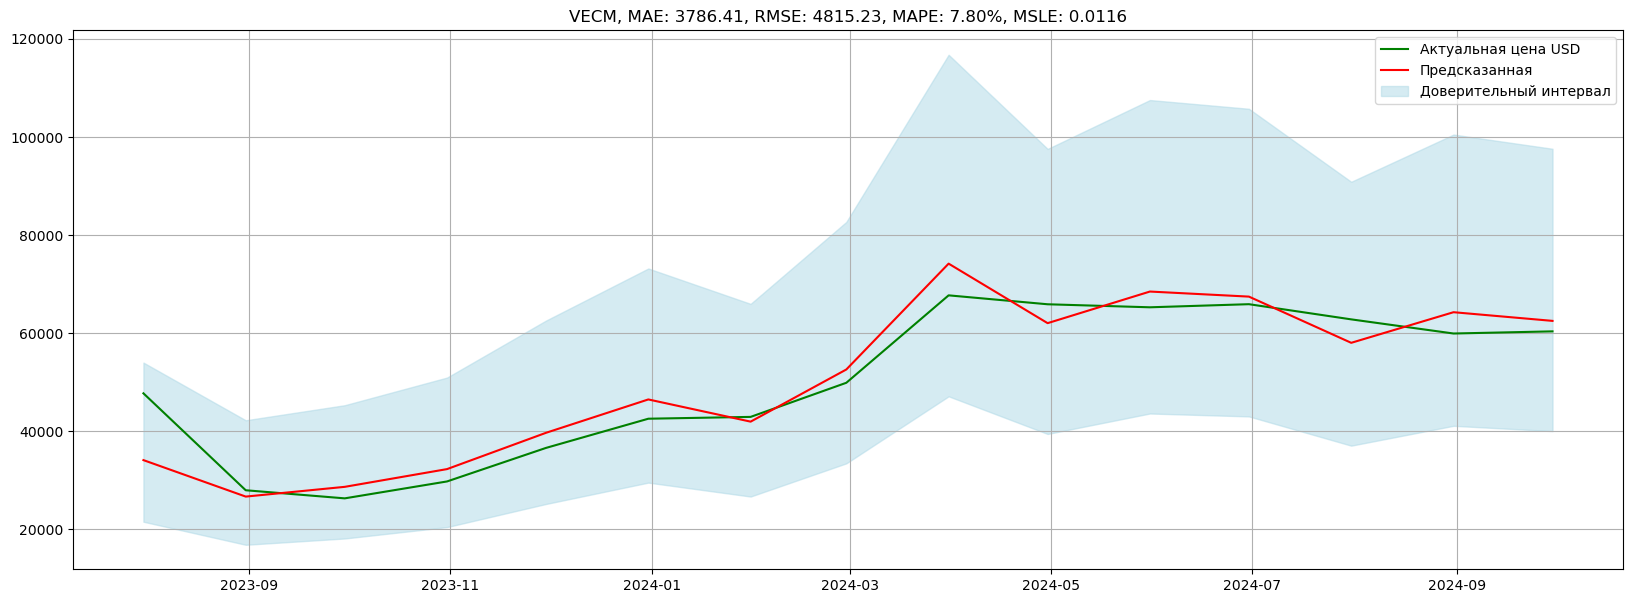

In [47]:
# Построение модели прогноза цены биткоин моделью VECM, третий вариант реализации, пошаговый
plt.rcParams["figure.figsize"] = (20, 7)

df_vecm = df_M.copy()

pred_dict = {'date': [], 'pred_price_usd': [], 'ci_lower': [], 'ci_upper': []}
period = 15
alpha = 0.01
k_ar_diff = 15

# Прогнозирование с использованием VECM
for i in tqdm(range(period)):
    training_data = df_vecm[['log_price', 'log_hash_rate']][:(-period + i)]
    model = VECM(training_data, coint_rank=1, k_ar_diff=k_ar_diff)
    model_fit = model.fit()
    pred, lower, upper = model_fit.predict(steps=1, alpha=alpha)
    
    pred_date = training_data.index[-1]
    pred_dict['date'].append(pred_date)
    pred_dict['pred_price_usd'].append(pred[0][0])
    pred_dict['ci_lower'].append(lower[0][0])
    pred_dict['ci_upper'].append(upper[0][0])

# Создание DataFrame для предсказаний
df_pred = pd.DataFrame(pred_dict)
df_pred = df_pred.set_index('date')
df_pred['log_price'] = df_vecm['log_price'][-period:]

# Заполнение пропусков средними значениями
df_pred['log_price'].fillna(df_pred['log_price'].mean(), inplace=True)
df_pred['pred_price_usd'].fillna(df_pred['pred_price_usd'].mean(), inplace=True)

# Преобразование логарифмов обратно в реальные значения
real_prices = np.exp(df_pred['log_price'])
predicted_real_prices = np.exp(df_pred['pred_price_usd'])

# Преобразование интервалов доверия из логарифмического масштаба в обычный
real_ci_lower = np.exp(df_pred['ci_lower'])
real_ci_upper = np.exp(df_pred['ci_upper'])

# Расчет метрик
mae = mean_absolute_error(real_prices, predicted_real_prices)
rmse = np.sqrt(mean_squared_error(real_prices, predicted_real_prices))
mape = np.mean(np.abs((real_prices - predicted_real_prices) / real_prices)) * 100
msle = mean_squared_log_error(real_prices, predicted_real_prices)

# Построение графика
plt.plot(real_prices, color='green', label='Актуальная цена USD')
plt.plot(predicted_real_prices, color='red', label='Предсказанная')
plt.fill_between(df_pred.index, real_ci_lower, real_ci_upper, color='lightblue', alpha=0.5, label='Доверительный интервал')
plt.legend()

# Добавление метрик в заголовок
plt.title(f"VECM, MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, MSLE: {msle:.4f}")
plt.grid()
plt.show()
